# Diffraction-limited Bigre IFU micropupil

*A. Bolton, 2023 Mar*

Notebook to explore Bigre PSF grids.

*Note on location of microslit image plane behind Bigre MLA:* The two elements of the Bigre MLA
are separated by the sum of their focal lengths $f_1$ and $f_2$. The design has $f_2 < f_1$
which is what gives the demagnification of the microslit image. The microslit image is effectively
the image of the front microlens as formed by the rear microlens. The lens equation entails that the
image distance $d$ behind the second ML satisfies
$${1 \over d} + {1 \over {(f_1 + f_2)}} = {1 \over {f_2}} \longrightarrow d = f_2 (1 + f_2 / f_1)$$
and also that the linear demagnification factor is $|\mu| = f_2 / f_1$. The role of the front microlens
is as a tiny field lens to concentrate all the light from the spaxel to go through the second
microlens.

### Toy model definition

The model is a 6.5m circular aperture with a central obscuration and
three supports, focusing onto a small square mask of size 40 mas that models
the Bigre input microlens aperture. We
use a primary tip-tilt stage to walk the telescope PSF across this aperture. 
Two lenses are used after the square mask
to form the Bigre micropupil and then to reimage
the Bigre microslit. No other masks or optics are modeled here.

The following cells define the model parameters, initialize the model,
and display the intermediate planes for one tip+tilt+wavelength.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
#from poppy.sub_sampled_optics import Subapertures, ShackHartmannWavefrontSensor
import astropy.units as u
import astropy.io.fits as fits
import copy

In [2]:
# Model parameters
fl_pri = 3607.5 * u.m  # primary beam focal length
diam = 6.5 * u.m       # primary aperture diameter
fs_size = .04          # 40 mas field stop for MLA aperture
fl_tiger = 0.0112 * u.m      # focal length of Tiger MLA lenslet
fl_bigre_1 = 14.68e-3 * u.m  # focal length of first Bigre MLA lenslet
fl_bigre_2 = 0.42e-3 * u.m   # focal length of second Bigre MLA lenslet
sec_rad = 0.65*u.m     # secondary radius
n_supp = 3             # number of secondary supports
supp_wid = 0.15*u.m    # width of secondary supports
npix = 1024            # number of pixels across pupil
detscale = 1.*u.micron/u.pixel # pixel scale of "detector" used to capture micropupil image
detfov = 64*u.pixel    # number of pixels across field of view of micropupil "detector"

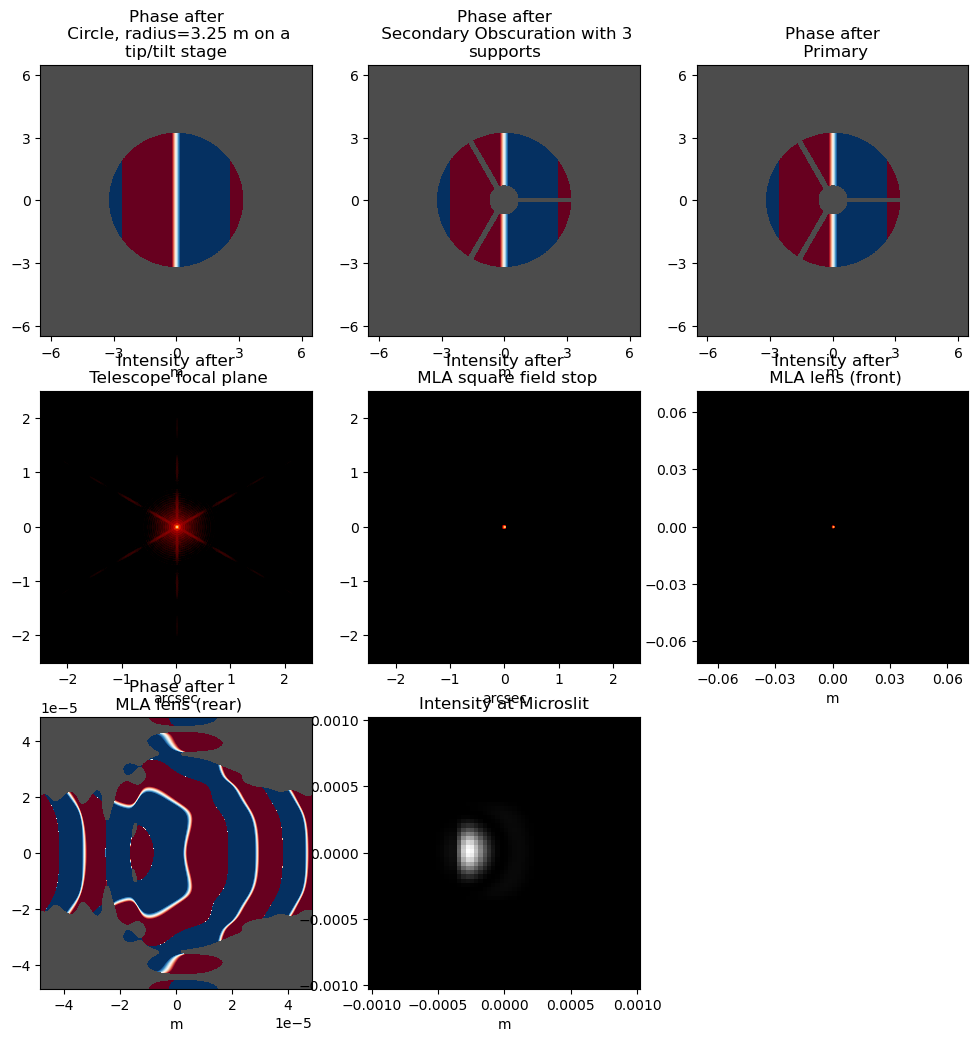

In [3]:
# Initialize model and display intermediate planes:
prim_ap = poppy.CircularAperture(radius=diam/2.)
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
#ttstage.set_tip_tilt(0.5*fs_size*u.arcsec, 0.5*fs_size*u.arcsec)
sqstop = poppy.SquareFieldStop(size=fs_size, name='MLA square field stop')
#sqstop.shift_x = 0. * fs_size
toy = poppy.FresnelOpticalSystem(pupil_diameter=2.*diam, npix=npix)
#toy.add_optic(prim_ap)
toy.add_optic(ttstage)
toy.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
toy.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
toy.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'), distance=fl_pri)
toy.add_optic(sqstop)
toy.add_optic(poppy.QuadraticLens(fl_bigre_1, name='MLA lens (front)'))
toy.add_optic(poppy.QuadraticLens(fl_bigre_2, name='MLA lens (rear)'), distance=(fl_bigre_1+fl_bigre_2))
toy.add_detector(pixelscale=detscale, fov_pixels=detfov, distance=fl_bigre_2*(1.+fl_bigre_2/fl_bigre_1))
toy.planes[-1].wavefront_display_hint = 'intensity'
toy.planes[-1].name = 'Microslit'
plt.figure(figsize=(12,12))
toy[0].set_tip_tilt(0.5*fs_size*u.arcsec, 0.*fs_size*u.arcsec)
psf, waves = toy.calc_psf(wavelength=.5*u.micron, display_intermediates=True, return_intermediates=True)

### Dependence on position of telescope PSF within lenslet

Now we calculate the Bigre output PSF over a grid of offsets of the telescope
PSF across the microlens aperture.

In [4]:
refwave = 1.0 * u.micron
x_shifts = [0., .25, .5, .75, 1.0]
y_shifts = [0., .25, .5, .75, 1.0]
#x_shifts = [0., .5, 1.]
#y_shifts = [0., .5]

psf_array = [[None for i in range(len(x_shifts))] for j in range(len(y_shifts))]

for j_shift, this_y_shift in enumerate(y_shifts):
    for i_shift, this_x_shift in enumerate(x_shifts):
        print(j_shift, i_shift)
        toy[0].set_tip_tilt(-this_x_shift*fs_size*u.arcsec, -this_y_shift*fs_size*u.arcsec)
        psf, waves = toy.calc_psf(wavelength=refwave, display_intermediates=False, return_intermediates=True)
        psf_array[j_shift][i_shift] = copy.deepcopy(waves[-1].intensity)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


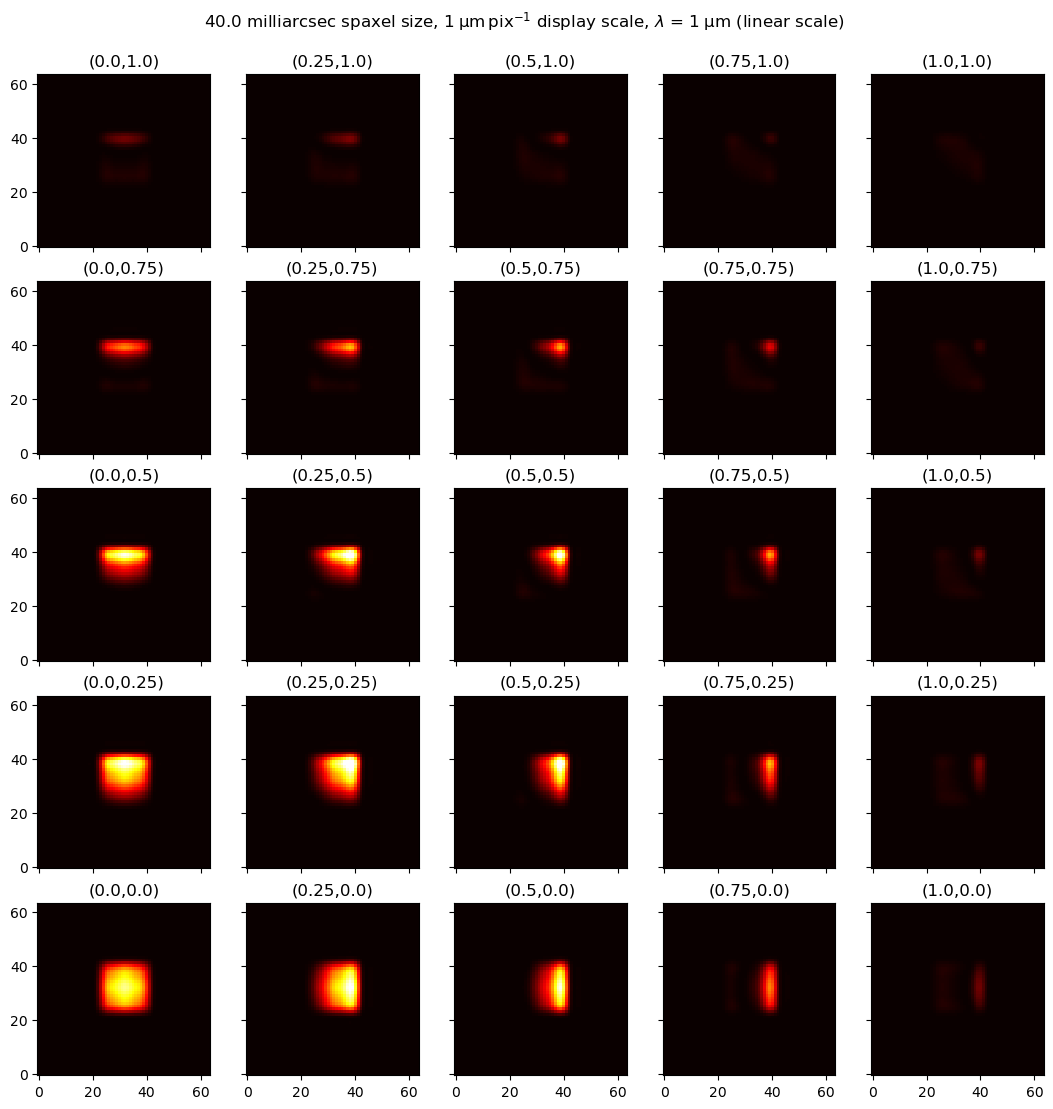

In [5]:
# Make plot (linear version)
n_x = len(x_shifts)
n_y = len(y_shifts)
fig, axis = plt.subplots(n_y, n_x, sharex=True, sharey=True)
for i in range(n_x):
    for j in range(n_y):
        jflip = n_y - j - 1
        axis[j,i].set_box_aspect(1)
        im_this = axis[j,i].imshow(psf_array[jflip][i], cmap='hot', interpolation='none', origin='lower', vmax=.003, vmin=0.)
        axis[j,i].set_title('(' + str(x_shifts[i]) + ',' + str(y_shifts[jflip])+ ')')

fig.set_figwidth(13)
fig.set_figheight(13)
junk = fig.suptitle(str(1000 * fs_size) + ' milliarcsec spaxel size, ' + 
                    detscale.to_string(format='latex_inline') + ' display scale, ' +
                    '$\lambda$ = ' + refwave.to_string(format='latex') + ' (linear scale)', y=.93)

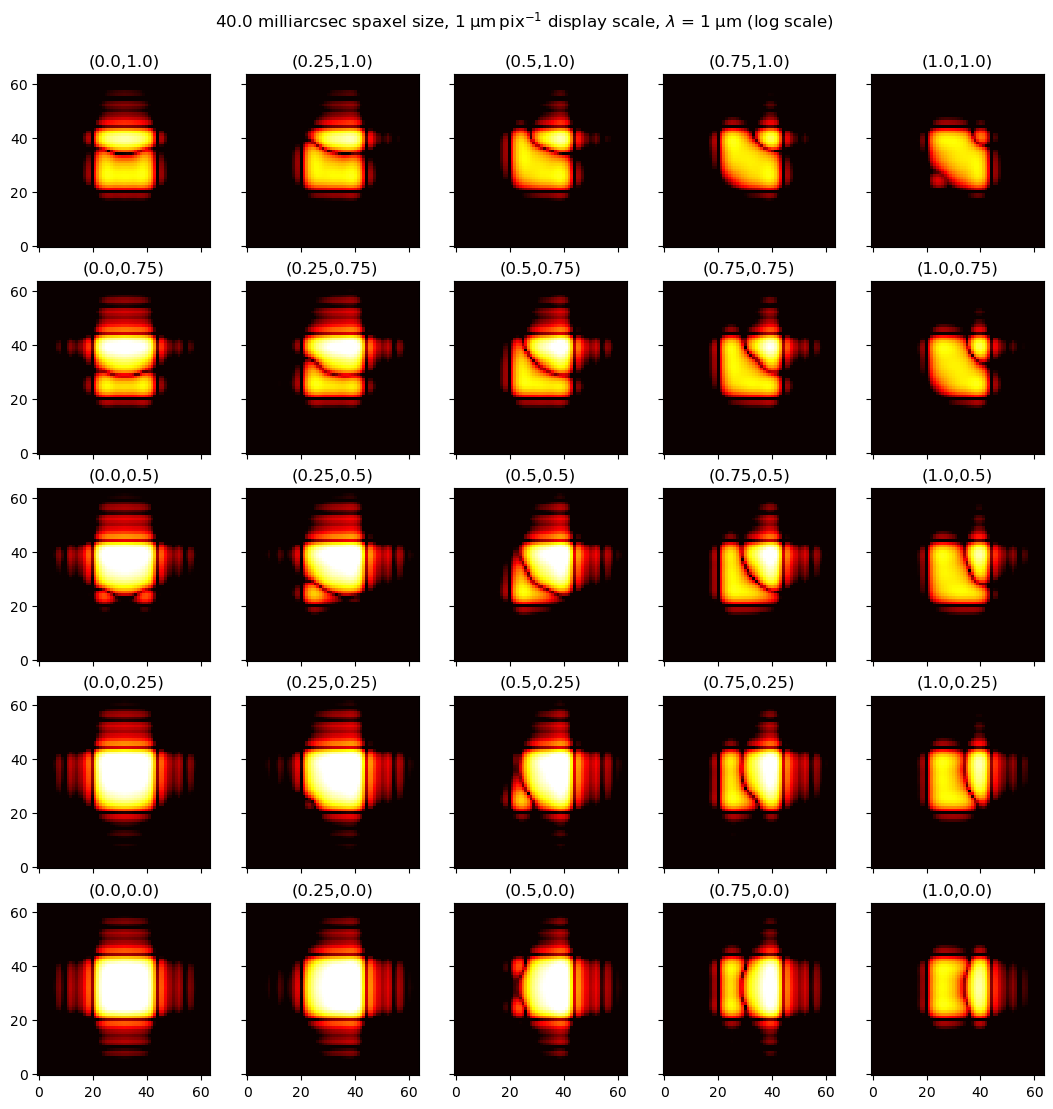

In [6]:
# Make plot (log version)
n_x = len(x_shifts)
n_y = len(y_shifts)
fig, axis = plt.subplots(n_y, n_x, sharex=True, sharey=True)
for i in range(n_x):
    for j in range(n_y):
        jflip = n_y - j - 1
        axis[j,i].set_box_aspect(1)
        im_this = axis[j,i].imshow(np.log10(np.maximum(psf_array[jflip][i], 1.e-7)), cmap='hot', interpolation='none', origin='lower', vmax=-3.)
        axis[j,i].set_title('(' + str(x_shifts[i]) + ',' + str(y_shifts[jflip])+ ')')

fig.set_figwidth(13)
fig.set_figheight(13)
junk = fig.suptitle(str(1000 * fs_size) + ' milliarcsec spaxel size, ' + 
                    detscale.to_string(format='latex_inline') + ' display scale, ' +
                    '$\lambda$ = ' + refwave.to_string(format='latex') + ' (log scale)', y=.93)